<a href="https://www.kaggle.com/code/fiftythirtyfour/usa-airline-delays-in-2015?scriptVersionId=173833743" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 📜Brief
## Introduction
Airlines has a very tight schedule because it wants to squeeze as many flights as possible. The more flights they have, the more money they make. Delays are a threat because if 1 flight has a delay, it affects the next flight and the next and so on... This creates a ripple effect that affects the entire network, which results to long delays or even cancellations. This is a big problem for an Airline because they operate on a fixed cost.

## Problem
How can we maximize the schedule and at the same time mitigate the effects of delays and flight disruption?

## Hypothesis
If we can predict the likelihood of flights to be delayed, we can plan the schedule better and maximize the flights by taking into account the potential delays.

## Goal
Predict the likelihood of delays of flights.

[kaggle](https://www.kaggle.com/code/fiftythirtyfour/usa-airline-delays-in-2015/edit)

# 🤓Data Science

In [1]:
! pip install airportsdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.0/911.0 kB 21.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
import airportsdata as ap

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 400

df = pd.read_csv('/kaggle/input/flight-delays/flights.csv')
rairline = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')
df.columns = df.columns.str.lower()

airports = pd.DataFrame(ap.load()).T
airports = airports.loc[airports['iata'] != '']
df['tz'] = df['origin_airport'].map(airports.set_index('iata')['tz'])

## Cleaning
df['scheduled_departure'] = [dt.time(x // 100, x % 100) for x in df['scheduled_departure']]
# df['scheduled_arrival'] = [dt.time(x // 100, x % 100) for x in df['scheduled_arrival']]
df['std_date'] = pd.to_datetime(df[['year', 'month', 'day']])

df['std_date_time'] = pd.to_datetime(df['std_date'].astype(str) + ' ' + df['scheduled_departure'].astype(str))
df['sta_date_time'] = df['std_date_time'] + pd.to_timedelta(df['scheduled_time'], unit='m')
df['atd_date_time'] = df['std_date_time'] + pd.to_timedelta(df['departure_delay'], unit='m')
df['ata_date_time'] = df['atd_date_time'] + pd.to_timedelta(df['elapsed_time'], unit='m')

df['anchor'] = df['airline'] + [str(x).zfill(5) for x in df['flight_number']] + '|' + df['std_date'].dt.strftime('%Y-%m-%d') + '|' + df['origin_airport'].astype(str)
df['otp_dly15'] = np.where(df['departure_delay'] > 15, 0.0, 1.0)

## Organize
dly = [x for x in df.columns if 'delay' in x]
num = [x for x in df.columns if df.dtypes[x] in ('float', 'int64')]
cat = [x for x in df.columns if df.dtypes[x] == "object"]
target = 'otp_dly15'
num.remove(target)

## Split
train = df.query('airline not in ("AA", "US", "OO")')
test = df.query('airline == "OO"')

## Merger of American and US Airways
There was a Merger of American Airlines and US Airways in June 2015. Southwest, Delta and American Airlines have the biggest voume of flights in 2015.

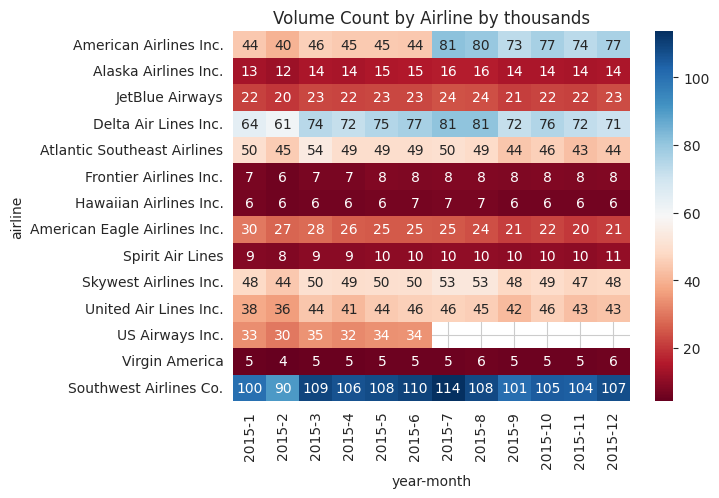

In [3]:
g = df.pivot_table('flight_number', index='airline'
              , columns=[df['year'], df['month']]
              , aggfunc='count') / 1000
g.index = g.index.map(rairline.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, cmap='RdBu', annot=True, fmt='.0f')

plt.title("Volume Count by Airline by thousands");

## Airline Departure On-Time Performance.
Why it is important for an Airline to depart on-time?

Airlines makes money by having their planes in the air. In a given period, each aircraft that an airline has would fly a route. Once, that aircraft reaches its destination, it will fly another route and make money. To maximize revenue, an airline would plan as many flights as possible. This results to a tight and strict schedule. When a flight is delayed, it will directly impact the next flight, which creates ripple effect that cascades delays to the series of flights. Therefore, it is critical that every flight departs on schedule or else, they will run the risk of flight distruption and airlines would lose the opportunity of making money.

In aviation, a flight is considered on time when it has departed within 15 minutes of scheduled departure time. Beyond that, it will be considered delayed. Airlines would space out their schedule to leave room for delays but when an aircraft is super delayed, then it would either bring out their spare aircraft or swap another aircraft that arrived early from another flight. As long as they deliver their passengers to their destination, it does not matter which aircraft they use. As long as they bring those passengers from point A to point B.

In the graph below, we can observe that the lower volume flights like Hawaiian, Virgin and Alaska Airlines are almost always on time. Delta and American airlines are also on time taking into consideration that they have more flights in 2015.

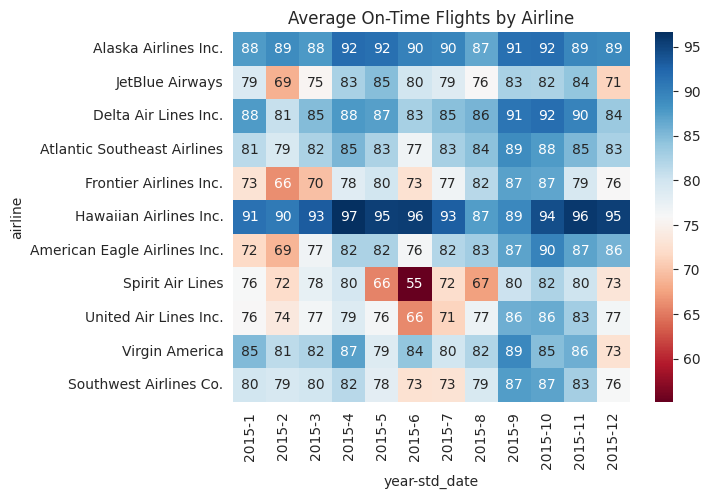

In [4]:
g = train.query('cancelled == 0 and diverted == 0')
g = g.pivot_table(target, index='airline'
             , columns=[g['year'], g['std_date'].dt.month]
             , aggfunc='mean')  * 100
g.index = g.index.map(rairline.set_index('IATA_CODE')['AIRLINE'])
sns.heatmap(g, annot=True, cmap='RdBu')
plt.title('Average On-Time Flights by Airline');

# 💪Work in Progress...
## Visualizing Flight Schedule
Goal: I want to visualize the flight schedule so that I can see how flight delays are affecting each other.

I have a problem with timezones. I calculated the schedule vs actual times correctly, but each airport has their own timezones. I need to change the timezones into UTC so that I can graph them in a uniform time.

There is a problem on airports origin/destination iata codes for October. All the airports are showing numeric numbers instead of 3 letter IATA codes. I am trying to fix it by using the flight_number and distance. I just need to figure out which iata code is which because each flight as 2 points. I am using the schedule time and see which one comes first and match them together and use that list to map the rest of the missing iata codes.

In [5]:
vx = train.query('airline=="VX"')

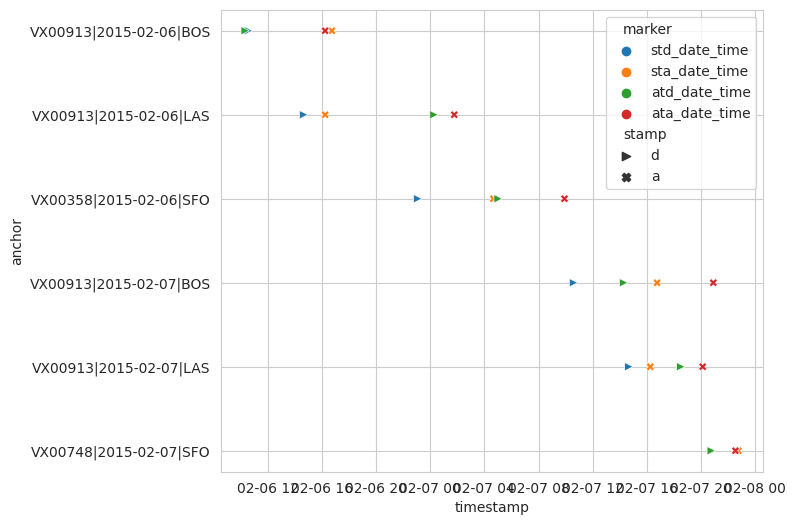

In [6]:
g = vx.query('tail_number == "N361VA"')
g = g.query('"2015-02-06" <= std_date <= "2015-02-07"')
g = g.loc[~g['departure_delay'].isnull()]
g = g[[
    'anchor'
    ,'std_date_time'
   , 'sta_date_time'    
   , 'atd_date_time'
   , 'ata_date_time'
#    , 'scheduled_time'
#        , 'elapsed_time'
#        , 'scheduled_arrival'
#        , 'arrival_time'
#        , 'arrival_delay'
#        , 'late_aircraft_delay'
#     , target
      ]]

g = g.sort_values(by='std_date_time')
# g['diff'] = (g['ata_date_time'] - g['sta_date_time']).dt.total_seconds() / 60
# g
g = pd.melt(g, id_vars='anchor', var_name='marker', value_name='timestamp')
g['stamp'] = g['marker'].str[2:3]
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot (g, x='timestamp', y='anchor'
                 , hue='marker'
                 , style='stamp'
                 , markers={'d': '>', 'a': 'X'}
                 , ax=ax);

In [7]:
g = df['origin_airport'].value_counts()
g[g>1000]

origin_airport
ATL      346836
ORD      285884
DFW      239551
DEN      196055
LAX      194673
SFO      148008
PHX      146815
IAH      146622
LAS      133181
MSP      112117
MCO      110982
SEA      110899
DTW      108500
BOS      107847
EWR      101772
CLT      100324
LGA       99605
SLC       97210
JFK       93811
BWI       86079
MDW       80886
DCA       73794
FLL       73624
SAN       70207
MIA       69341
PHL       66021
TPA       63906
DAL       59699
HOU       52042
BNA       47580
PDX       47085
STL       46963
HNL       43172
OAK       42316
AUS       42067
MSY       38804
MCI       38665
SJC       38200
SMF       37212
SNA       37187
CLE       34589
IAD       34305
RDU       31896
10397     30824
MKE       29825
SAT       29788
RSW       27350
13930     26117
IND       25558
SJU       24656
CMH       24187
PIT       24118
PBI       22573
OGG       20627
CVG       20031
11298     19840
ABQ       19192
BUR       18889
BDL       18799
JAX       18038
ONT       17978
11292    

In [8]:
df['tz']

0            America/Anchorage
1          America/Los_Angeles
2          America/Los_Angeles
3          America/Los_Angeles
4          America/Los_Angeles
                  ...         
5819074    America/Los_Angeles
5819075       America/New_York
5819076       America/New_York
5819077       America/New_York
5819078       America/New_York
Name: tz, Length: 5819079, dtype: object

In [9]:
df['std_ls_date_time'] = df[['std_date_time', 'tz']].apply(lambda x: 
                                  x['std_date_time'].tz_localize(
                                      x['tz'], ambiguous='NaT')
                                  if pd.notna(x['std_date_time']) 
                                  and pd.notna(x['tz']) else pd.NaT, axis=1)

In [10]:
df['std_ls_date_time']

0          2015-01-01 00:05:00-09:00
1          2015-01-01 00:10:00-08:00
2          2015-01-01 00:20:00-08:00
3          2015-01-01 00:20:00-08:00
4          2015-01-01 00:25:00-08:00
                     ...            
5819074    2015-12-31 23:59:00-08:00
5819075    2015-12-31 23:59:00-05:00
5819076    2015-12-31 23:59:00-05:00
5819077    2015-12-31 23:59:00-05:00
5819078    2015-12-31 23:59:00-05:00
Name: std_ls_date_time, Length: 5819079, dtype: object

In [11]:
g = df.loc[df['tz'].isnull() & (df['origin_airport'].str.len() != 3)]
g['origin_airport'].value_counts()
g.groupby(['origin_airport', 'destination_airport' , 'airline', 'flight_number'])['anchor'].count()

origin_airport  destination_airport  airline  flight_number
10135           10397                DL       1076              4
                                              2561             25
                                     EV       5033             25
                                              5066              4
                                              5317             25
                                                               ..
16218           14107                OO       2961              2
                                              2963              1
                                              2968              2
                                              2991              1
                                              2992              2
Name: anchor, Length: 48943, dtype: int64

In [12]:
df.dtypes

year                            int64
month                           int64
day                             int64
day_of_week                     int64
airline                        object
flight_number                   int64
tail_number                    object
origin_airport                 object
destination_airport            object
scheduled_departure            object
departure_time                float64
departure_delay               float64
taxi_out                      float64
wheels_off                    float64
scheduled_time                float64
elapsed_time                  float64
air_time                      float64
distance                        int64
wheels_on                     float64
taxi_in                       float64
scheduled_arrival               int64
arrival_time                  float64
arrival_delay                 float64
diverted                        int64
cancelled                       int64
cancellation_reason            object
air_system_d

In [13]:
df['origin_airport'] = df['origin_airport'].astype(str)
df['destination_airport'] = df['destination_airport'].astype(str)

In [14]:
g = df.loc[(df['airline'] == 'DL') & (df['flight_number'] == 1858)]
g = g.groupby([
    'scheduled_departure'
    , 'flight_number'
    , 'origin_airport'])['distance'].mean().sort_values().reset_index()
h = g.groupby('distance')['origin_airport'].nunique()
h = h[h>1].index
g = g.loc[g['distance'].isin(h)]
g.groupby(['distance'
           , g['origin_airport'].str.len() > 3
           , 'origin_airport'
           
          ])['scheduled_departure'].min()

distance  origin_airport  origin_airport
813.0     False           ATL               09:40:00
                          AUS               10:45:00
          True            10397             09:40:00
                          10423             11:50:00
Name: scheduled_departure, dtype: object

In [15]:
g = df.loc[(df['airline'] == 'DL') 
           & (df['origin_airport'].str.len() > 3)]
# g = g[['origin_airport', 'destination_airport', 'flight_number']]
g.groupby(['flight_number'])['anchor'].count().sort_values()

flight_number
718      1
2318     1
1430     1
2476     1
441      1
        ..
1863    62
1864    62
1127    62
2236    62
881     62
Name: anchor, Length: 2199, dtype: int64